In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy as sy
from scipy.integrate import odeint

In [ ]:
hi,V0 = sp.symbols('phi V0',real =True)


V=V0*(sp.exp(phi)-1)**2
dVdphi = sp.diff(V,phi)
lam = -1/V dVdphi

lam_simplified = sp.simplify(lam)
print("lam(phi) =", lam_simplified)
print(f"V' = {dVdphi}")

lam(phi) = 2*exp(phi)/(1 - exp(phi))
V' = 2*V0*(exp(phi) - 1)*exp(phi)


Physical fixed points: [[0. 0.]]
Fixed points (0.0,0.0)
Eigen Values: [0.+1.41421356j 0.-1.41421356j]
Type=Spiral
Stability=Centre



/tmp/ipykernel_1732/3819848741.py:2: RuntimeWarning: invalid value encountered in scalar power
  dpsi = -2*np.exp(phi/np.sqrt(1-phi**2))*(np.exp(phi/np.sqrt(1-phi**2))-1)*(1-psi**2)**1.5
/tmp/ipykernel_1732/3819848741.py:3: RuntimeWarning: invalid value encountered in sqrt
  dphi = (1-phi**2)**(1.5) *psi/(np.sqrt(1-psi**2))


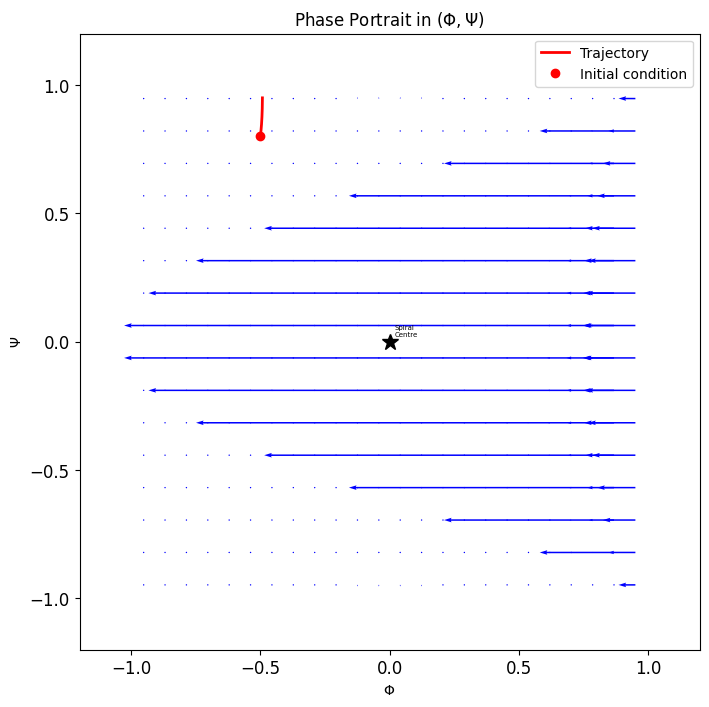

In [ ]:
def dynamicsStateSpace(phi,psi):
  dpsi = -2*np.exp(phi/np.sqrt(1-phi**2))*(np.exp(phi/np.sqrt(1-phi**2))-1)*(1-psi**2)**1.5
  dphi = (1-phi**2)**(1.5) *psi/(np.sqrt(1-psi**2))

  return [dpsi,dphi]

# defining a grid of points at which we create/compute tangent arrows
x0 = np.linspace(-1.2,1.2,30)
x1 = np.linspace(-1.2,1.2,20)
X0,X1 = np.meshgrid(x0,x1)
dX0 = np.zeros(X0.shape)
dX1 = np.zeros(X1.shape)
#shape1,shape2 = X1.shape

for i in range(X0.shape[0]):
    for j in range(X0.shape[1]):
        if abs(X0[i,j]) < 1 and abs(X1[i,j]) < 1:

            a,b = dynamicsStateSpace(X0[i,j], X1[i,j])
            dX0[i,j] = a
            dX1[i,j] = b
        else:
            dX0[i,j] = np.nan
            dX1[i,j] = np.nan

phi_FP, psi_FP = sp.symbols('x y', real=True)

f = -2*sp.exp(phi_FP/sp.sqrt(1-phi_FP**2))*(sp.exp(phi_FP/sp.sqrt(1-phi_FP**2))-1)*(1-psi_FP**2)**1.5

g = (1-phi_FP**2)**(1.5) *psi_FP/(sp.sqrt(1-psi_FP**2))



J_sym = sp.Matrix([g, f]).jacobian([phi_FP, psi_FP]) # Symbolic Jacobian

solutions = sp.solve([f, g], [phi_FP, psi_FP], dict=True)
FP=[]
for sol in solutions:
    phi_val = sol[phi_FP]
    psi_val = sol[psi_FP]
    if phi_val.is_real and psi_val.is_real:
        FP.append([float(phi_val), float(psi_val)])
FP=np.array(FP)
print("Physical fixed points:", FP)



def dynamics_odeint(X,N):
  phi,psi = X
  dphi,dpsi = dynamicsStateSpace(phi,psi)
  return [dphi,dpsi]


plt.figure(figsize=(8,8))
plt.quiver(X0, X1, dX0, dX1, color='b')
plt.xlabel(rf"$\Phi$")
plt.ylabel(rf"$\Psi$")
plt.title(rf"Phase Portrait in $(\Phi,\Psi)$")
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tick_params(axis='both', which='major', labelsize=12)



# plot the dynamics on the same graph
initialState=np.array([-0.5,0.8])
simulationTime=np.linspace(0,5,200)
# generate the state-space trajectory
solutionState=odeint(dynamics_odeint,initialState,simulationTime)

plt.plot(solutionState[:,0],solutionState[:,1],'r-',linewidth=2,label='Trajectory')
plt.plot(solutionState[0,0], solutionState[0,1], 'ro', label="Initial condition")

def classify_FP(eigvals,temp=1e-10):
  Real = np.real(eigvals)
  Imag = np.imag(eigvals)
  if np.all(Real<-temp):
    stability = 'Attractor'
  elif np.all(Real>temp):
    stability = 'Repeller'
  elif np.all(Real<-temp) and np.any(Real > temp):
    stability = 'saddle'
  elif np.all(np.abs(Real) < temp):
    stability = 'Centre'
  else:
    stability = 'NaN'
  if np.any(np.abs(Imag)>temp):
    point_type = 'Spiral'
  else:
    point_type = 'node'

  return stability,point_type

for fp in FP:
  phi_c, psi_c = fp
  J_num = np.array(J_sym.subs({phi_FP:phi_c,psi_FP:psi_c}),dtype=float)
  eigvals = np.linalg.eigvals(J_num)
  stability,point_type = classify_FP(eigvals)
  print(f'Fixed points ({phi_c:},{psi_c})')
  print('Eigen Values:',eigvals)
  print(f'Type={point_type}')
  print(f'Stability={stability}\n')
  plt.plot(phi_c, psi_c, 'k*', markersize=12)
  plt.text(phi_c+0.02, psi_c+0.02, f"{point_type}\n{stability}", fontsize=5)



plt.legend()
plt.show()




# https://aleksandarhaber.com/phase-portraits-of-state-space-models-and-differential-equations-in-python/


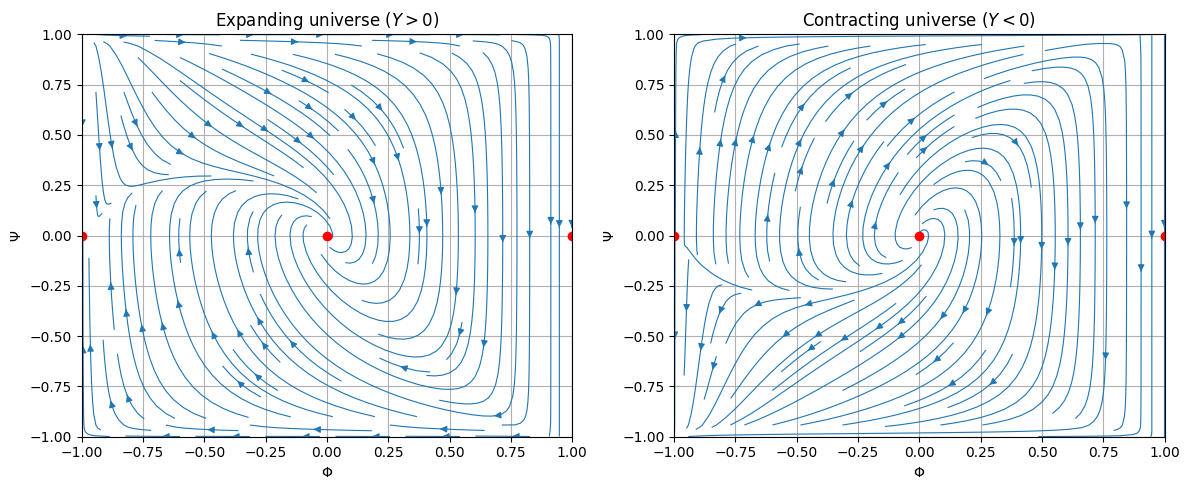

In [8]:
# ============================================================
# Emergent Universe Phase Space (Burdman & Bruni)
# Compact variables Φ, Ψ with expanding/contracting branches
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Compact phase-space dynamics (flat FLRW submanifolds)
# ------------------------------------------------------------
def dynamics_PhiPsi(Phi, Psi, Y):
    """
    Compact dynamical system for Φ, Ψ
    Y > 0 : expanding universe
    Y < 0 : contracting universe
    """

    # avoid singular boundary exactly at |Φ|=1, |Ψ|=1
    if abs(Phi) >= 1 or abs(Psi) >= 1:
        return 0.0, 0.0

    # inverse compactification
    phi = Phi / np.sqrt(1 - Phi**2)

    # Φ equation
    dPhi = Psi * (1 - Phi**2)**1.5 / np.sqrt(1 - Psi**2)

    # Ψ equation (includes Hubble friction)
    dPsi = (
        -3 * Y * Psi * np.sqrt(1 - Psi**2)
        -2 * (1 - Psi**2)**1.5
          * np.exp(phi) * (np.exp(phi) - 1)
    )

    return dPhi, dPsi


# ------------------------------------------------------------
# Vector field generator
# ------------------------------------------------------------
def compute_vector_field(Y, N=40):
    Phi = np.linspace(-0.999, 0.999, N)
    Psi = np.linspace(-0.999, 0.999, N)
    PHI, PSI = np.meshgrid(Phi, Psi)

    U = np.zeros_like(PHI)
    V = np.zeros_like(PSI)

    for i in range(N):
        for j in range(N):
            U[i, j], V[i, j] = dynamics_PhiPsi(PHI[i, j], PSI[i, j], Y)

    return PHI, PSI, U, V


# ------------------------------------------------------------
# Detect fixed points near compactified infinity
# ------------------------------------------------------------
def detect_boundary_FPs(Y, tol=1e-3):
    FPs = []
    for Phi in [0.999, -0.999]:
        for Psi in np.linspace(-0.05, 0.05, 50):
            dPhi, dPsi = dynamics_PhiPsi(Phi, Psi, Y)
            if abs(dPhi) < tol and abs(dPsi) < tol:
                FPs.append((Phi, Psi))
    return FPs


# ------------------------------------------------------------
# Plot expanding vs contracting branches
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

branches = {
    "Expanding universe $(Y>0)$": +0.5,
    "Contracting universe $(Y<0)$": -0.5
}

for ax, (label, Yval) in zip(axes, branches.items()):
    PHI, PSI, U, V = compute_vector_field(Yval)

    # phase flow
    ax.streamplot(PHI, PSI, U, V, density=1.2, linewidth=0.8)

    # physical fixed points
    fixed_points = [(0, 0), (1, 0), (-1, 0)]
    for fp in fixed_points:
        ax.plot(fp[0], fp[1], 'ro')

    # detect asymptotic FPs (diagnostic)
    boundary_fps = detect_boundary_FPs(Yval)
    for fp in boundary_fps:
        ax.plot(fp[0], fp[1], 'kx')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(r'$\Phi$')
    ax.set_ylabel(r'$\Psi$')
    ax.set_title(label)
    ax.grid(True)

plt.tight_layout()
plt.show()
